<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# Profiling and Scaling Analysis of the NetworkSedimentTransporter

Part 1: Do some stuff to give us generic, variable sized grids and parcels. 
Part 2: Do some profiling. 
Part 2: Do some scaling analysis.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
from landlab.components import FlowDirectorSteepest, NetworkSedimentTransporter
from landlab.data_record import DataRecord
from landlab.grid.network import NetworkModelGrid
from landlab.plot import graph

## Part 1: Variably-sized grids and parcels

### Part 1a: Grids

First, we need the ability to create different sizes of grids. 

A simple approach is to create a generic grid in which each node has two recievers. Lets start by writing a function that creates the x and y node coordinates and the linking structure for a given number of layers.   

I haven't tried to optimize this at all. 

In [2]:
def create_node_xy_and_links(n_layers, x0=0., y0=0., xperc=0.9, dy=1.):
    assert xperc<1.0
    nodes_per_layer = np.power(2, np.arange(n_layers+1))
    nnodes = np.sum(nodes_per_layer)   
    x_of_node=[x0]
    y_of_node=[y0]
    nodes_at_link = []
    id_start_layer = 0
    for nl in np.arange(1, n_layers+1):
        nodes_last_layer = np.power(2, nl-1)
        nodes_this_layer = np.power(2, nl)              
        dx = xperc * (dy)*(0.5**(nl-1))
        for ni in range(nodes_last_layer):
            head_id = id_start_layer+ni            
            tail_id = len(x_of_node)           
            x = x_of_node[head_id]
            y = y_of_node[head_id]            
            x_of_node.extend([x-dx, x+dx])
            y_of_node.extend([y+dy, y+dy])            
            nodes_at_link.extend([(head_id, tail_id), (head_id, tail_id +1)])   
        id_start_layer = len(x_of_node) - nodes_this_layer
    return x_of_node, y_of_node, nodes_at_link

Lets demonstrate the different sorts of grids we get with different numbers of layers

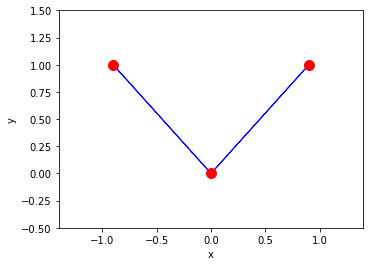

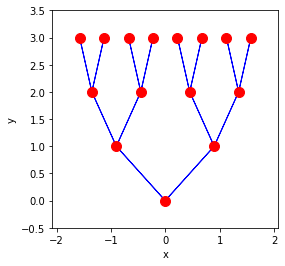

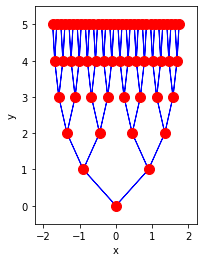

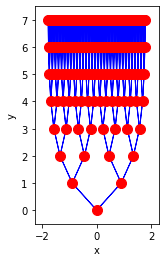

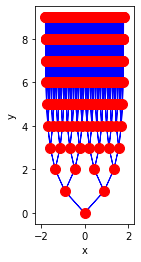

In [11]:
example_layers = [1, 3, 5, 7, 9]

nodes = []
links = []
for i, n_layers in enumerate(example_layers):
    x_of_node, y_of_node, nodes_at_link = create_node_xy_and_links(n_layers)
    grid = NetworkModelGrid((y_of_node, x_of_node), nodes_at_link)

    graph.plot_graph(grid, at="node,link", with_id=False)
    nodes.append(grid.number_of_nodes)
    links.append(grid.number_of_links)

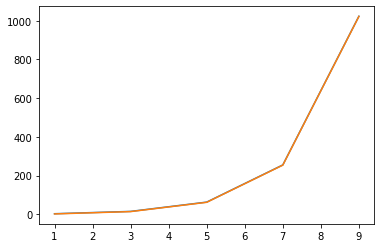

In [12]:
plt.plot(example_layers, nodes)
plt.plot(example_layers, links)

### 1b: Generic sets of parcels
A real application would likley use 50k+ parcels (b/c you want the full gsd) and 100-500 links in the network. 
You typically want at least 100 parcels per link. 


In [ ]:
grid.at_node["topographic__elevation"] = [0.0, 0.08, 0.25, 0.15, 0.25, 0.4, 0.8, 0.8]
grid.at_node["bedrock__elevation"] = [0.0, 0.08, 0.25, 0.15, 0.25, 0.4, 0.8, 0.8]

area = grid.add_ones("cell_area_at_node", at="node") # AP ????

# Set geometry for each link
#grid.at_link["drainage_area"] = np.ones(grid.number_of_links) # don't need?
grid.at_link["channel_slope"] = np.ones(grid.number_of_links) # AP ?? Does it get overwritten?? check
grid.at_link["link_length"] = 200*np.ones(grid.number_of_links)  # m
grid.at_link["channel_width"] = 1*np.ones(grid.number_of_links)

# element_id is the link on which the parcel begins. 
element_id = np.repeat(np.arange(grid.number_of_links),5)
element_id = np.expand_dims(element_id, axis=1)

volume = 1*np.ones(np.shape(element_id))  # (m3)
active_layer = np.ones(np.shape(element_id)) # 1= active, 0 = inactive
density = 2650 * np.ones(np.size(element_id))  # (kg/m3)
abrasion_rate = 0 * np.ones(np.size(element_id)) # (mass loss /m)

# Lognormal GSD
medianD = 0.085 # m
mu = np.log(medianD)
sigma = np.log(2) #assume that D84 = sigma*D50
np.random.seed(0)
D = np.random.lognormal(
    mu,
    sigma,
    np.shape(element_id)
)  # (m) the diameter of grains in each parcel

time_arrival_in_link = np.random.rand(np.size(element_id), 1) 
location_in_link = np.random.rand(np.size(element_id), 1) 

lithology = ["quartzite"] * np.size(element_id)


variables = {
    "abrasion_rate": (["item_id"], abrasion_rate),
    "density": (["item_id"], density),
    "lithology": (["item_id"], lithology),
    "time_arrival_in_link": (["item_id", "time"], time_arrival_in_link),
    "active_layer": (["item_id", "time"], active_layer),
    "location_in_link": (["item_id", "time"], location_in_link),
    "D": (["item_id", "time"], D),
    "volume": (["item_id", "time"], volume)
}


items = {"grid_element": "link", "element_id": element_id}

_OUT_OF_NETWORK = NetworkModelGrid.BAD_INDEX - 1

parcels = DataRecord(
    grid,
    items=items,
    time=[0.0],
    data_vars=variables,
    dummy_elements={"link": [_OUT_OF_NETWORK]},
)


In [ ]:
timesteps = 10 # total number of timesteps
dt = 60 * 60 * 24 *12 # length of timestep (seconds) 

In [ ]:
flow_depth =  2.5 * np.ones([timesteps + 1,grid.number_of_links])
fd = FlowDirectorSteepest(grid, "topographic__elevation")
fd.run_one_step()


nst = NetworkSedimentTransporter(    
    grid,
    parcels,
    fd,
    flow_depth,
    bed_porosity=0.3,
    g=9.81,
    fluid_density=1000,
    transport_method="WilcockCrowe",
)

for t in range(0, (timesteps * dt), dt):
    nst.run_one_step(dt)
    
    print("Model time: ", t/(60*60*24), "days passed")